<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Patent-Numbers" data-toc-modified-id="Patent-Numbers-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Patent Numbers</a></span><ul class="toc-item"><li><span><a href="#Processing" data-toc-modified-id="Processing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Processing</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Applicants" data-toc-modified-id="Applicants-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Applicants</a></span></li><li><span><a href="#Primary-Examiners" data-toc-modified-id="Primary-Examiners-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Primary Examiners</a></span></li><li><span><a href="#Attorneys" data-toc-modified-id="Attorneys-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Attorneys</a></span></li><li><span><a href="#Publication-Dates" data-toc-modified-id="Publication-Dates-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Publication Dates</a></span></li></ul></div>

In [293]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from scipy import stats
import datetime as dt
import re
import statistics
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from textblob import TextBlob
import numpy as np
plt.style.use('seaborn-poster')
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [224]:

in_paths = ['microbiome_patents', 'probiotic_patents']
if (len(in_paths) == 1) or (isinstance(in_paths, str)):
    with open(f'{in_path}.json', 'r') as f:
        patent_data = json.load(f)
elif len(in_paths) > 1:
    patent_data = {}
    for in_path in in_paths:
        with open(f'{in_path}.json', 'r') as f:
            tmp_data = json.load(f)
        patent_data.update(tmp_data)

patent_ids = [i for i in list(patent_data.keys())]
terms = [i.split('_')[0] for i in patent_ids]
print('Terms found in the data include:', set(terms), '\n')
for term in set(terms):
    term_ids = [i.split('_')[1] for i in patent_ids if i.split('_')[0] == term]
    print(f'Minimum {term} patent result number : {min(term_ids)}\nMaximum {term} patent result number : {max(term_ids)}')


Terms found in the data include: {'microbiome', 'probiotic'} 

Minimum microbiome patent result number : 000001
Maximum microbiome patent result number : 001084
Minimum probiotic patent result number : 000001
Maximum probiotic patent result number : 001100


In [225]:
### Reminder of keys in dictionary
list(list(patent_data.values())[0].keys())

['page_url',
 'primary_examiner',
 'attorney',
 'publication_date',
 'document_number',
 'patent_number',
 'inventors',
 'applicant',
 'abstract',
 'claims',
 'cited_references',
 'other_references']

### Patent Numbers

#### Processing

In [226]:
patent_numbers = [int(i['document_number'].replace(',', '')) for i in patent_data.values()]
patent_numbers = [i for i in patent_numbers if i > 2]
patent_numbers_stdev = statistics.stdev(patent_numbers)
patent_numbers_mean = statistics.mean(patent_numbers)
patent_numbers_z = [(i-patent_numbers_mean) / patent_numbers_stdev for i in patent_numbers]
print(f'Minimum patent number : {min(patent_numbers)}\nMaximum patent number : {max(patent_numbers)}')
print(f'Minimum patent z-score : {min(patent_numbers_z)}\nMaximum patent z-score : {max(patent_numbers_z)}')
print(f'Unscaled summary : \n{stats.describe(patent_numbers)}')
print(f'Scaled summary : \n{stats.describe(patent_numbers_z)}')


Minimum patent number : 46718
Maximum patent number : 10494684
Minimum patent z-score : -17.761614911932067
Maximum patent z-score : 0.8760107079453691
Unscaled summary : 
DescribeResult(nobs=2182, minmax=(46718, 10494684), mean=10003605.88313474, variance=314255099588.17847, skewness=-9.624231587389268, kurtosis=154.70729461287024)
Scaled summary : 
DescribeResult(nobs=2182, minmax=(-17.761614911932067, 0.8760107079453691), mean=-1.237425479325564e-15, variance=1.0, skewness=-9.624231587389271, kurtosis=154.70729461287024)


#### Plot

The abnormal distribution of the patent numbers makes it difficult to show all the data but below, I've plotted a lightly truncated version of the plot showing a clear left skew. 

This indicates that a bulk of these patents were published recently which conforms with reality as the microbiome space is recently gaining popularity. 

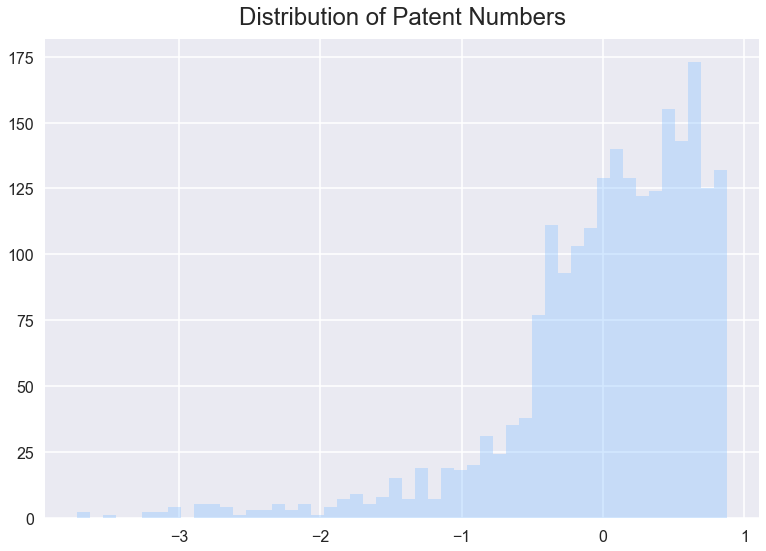

In [227]:
fig = plt.figure(facecolor='white')
sns.distplot([i for i in patent_numbers_z if i > -15], kde=False, bins=50)
plt.title('Distribution of Patent Numbers', fontsize=24, pad=15)
sns.despine()
plt.show()

### Applicants

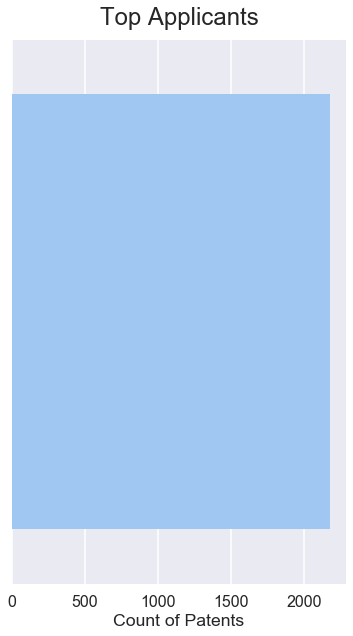

In [286]:
applicants = [i['applicant'] for i in patent_data.values()]
#PEs = [i.split('; ')[1] + ' ' + i.split('; ')[0] for i in PEs]
applicant_count = dict(collections.Counter(applicants))
n = 25
top_applicant_list = sorted(applicant_count, key=applicant_count.get, reverse=True)[:n]
top_applicantcount_list = [applicant_count[i] for i in top_applicant_list]

fig = plt.figure(figsize=(6,10), facecolor='white')
sns.barplot(top_applicantcount_list, top_applicant_list)
sns.despine()
plt.title('Top Applicants', fontsize=24, pad=15)
plt.xlabel('Count of Patents')
plt.show()

### Primary Examiners

First I'll plot the most common primary examiners. 

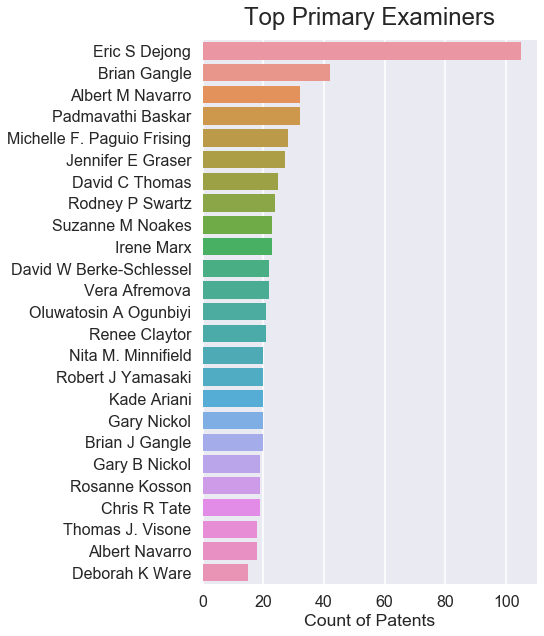

In [285]:
PEs = [i['primary_examiner'] for i in patent_data.values()]
PEs = [i.split('; ')[1] + ' ' + i.split('; ')[0] for i in PEs]
PEs_count = dict(collections.Counter(PEs))
n = 25
top_PE_list = sorted(PEs_count, key=PEs_count.get, reverse=True)[:n]
top_PEcount_list = [PEs_count[i] for i in top_PE_list]

fig = plt.figure(figsize=(6,10), facecolor='white')
sns.barplot(top_PEcount_list, top_PE_list)
sns.despine()
plt.title('Top Primary Examiners', fontsize=24, pad=15)
plt.xlabel('Count of Patents')
plt.show()

### Attorneys

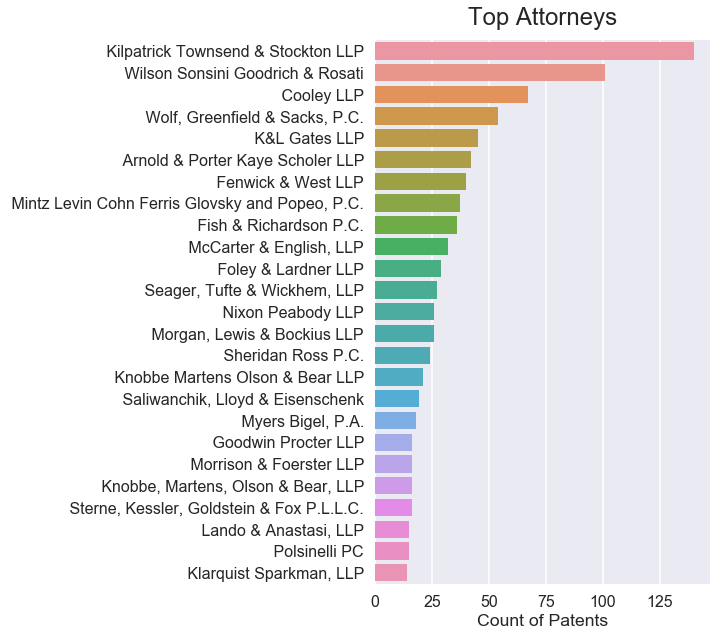

In [229]:
attorneys = [i['attorney'] for i in patent_data.values() if i['attorney'] != '']
attorneys = [i.replace('amp;', '') for i in attorneys]
attorneys_count = dict(collections.Counter(attorneys))
n = 25
top_attorney_list = sorted(attorneys_count, key=attorneys_count.get, reverse=True)[:n]
top_att_count_list = [attorneys_count[i] for i in top_attorney_list]

fig = plt.figure(figsize=(6,10), facecolor = 'white')
sns.barplot(top_att_count_list, top_attorney_list)
plt.title('Top Attorneys', fontsize=24, pad=15)
plt.xlabel('Count of Patents')
plt.show()

### Publication Dates

In [230]:
pub_dates = [i['publication_date'] for i in patent_data.values() if i['publication_date'] != '']
pub_dates = [i.replace('rch', 'Mar').replace('ary', 'Feb').replace('ust', 'Aug') for i in pub_dates]
pub_dates = [i.replace('ril', 'Apr').replace('une', 'Jun').replace('uly', 'Jul') for i in pub_dates]


### One could argue this substitution but the effect is minor
pub_dates = [i.replace('ber', 'Oct') for i in pub_dates]
#pub_dates = [i.replace('ber', 'Nov') for i in pub_dates]
pub_dates = [dt.datetime.strptime(i, '%b %d, %Y') for i in pub_dates]

In [231]:
pub_quarters = [str(i.year) + '-' + f'{pd.Timestamp(i).quarter}' for i in pub_dates]
pub_quarter_count = dict(collections.Counter(pub_quarters))
n = 25
top_pubquarter_list = sorted(pub_quarter_count, key=pub_quarter_count.get, reverse=True)[:n]
top_pubquarter_count_list = [pub_quarter_count[i] for i in top_pubquarter_list]


pub_years = [str(i.year) for i in pub_dates]
pub_year_count = dict(collections.Counter(pub_years))
n = 25
top_pubyear_list = sorted(pub_year_count, key=pub_year_count.get, reverse=True)[:n]
top_pubyear_count_list = [pub_year_count[i] for i in top_pubyear_list]


all_pub_quarters_list = sorted(pub_quarter_count, reverse=False)
all_pubquarter_count_list = [pub_quarter_count[i] for i in all_pub_quarters_list]

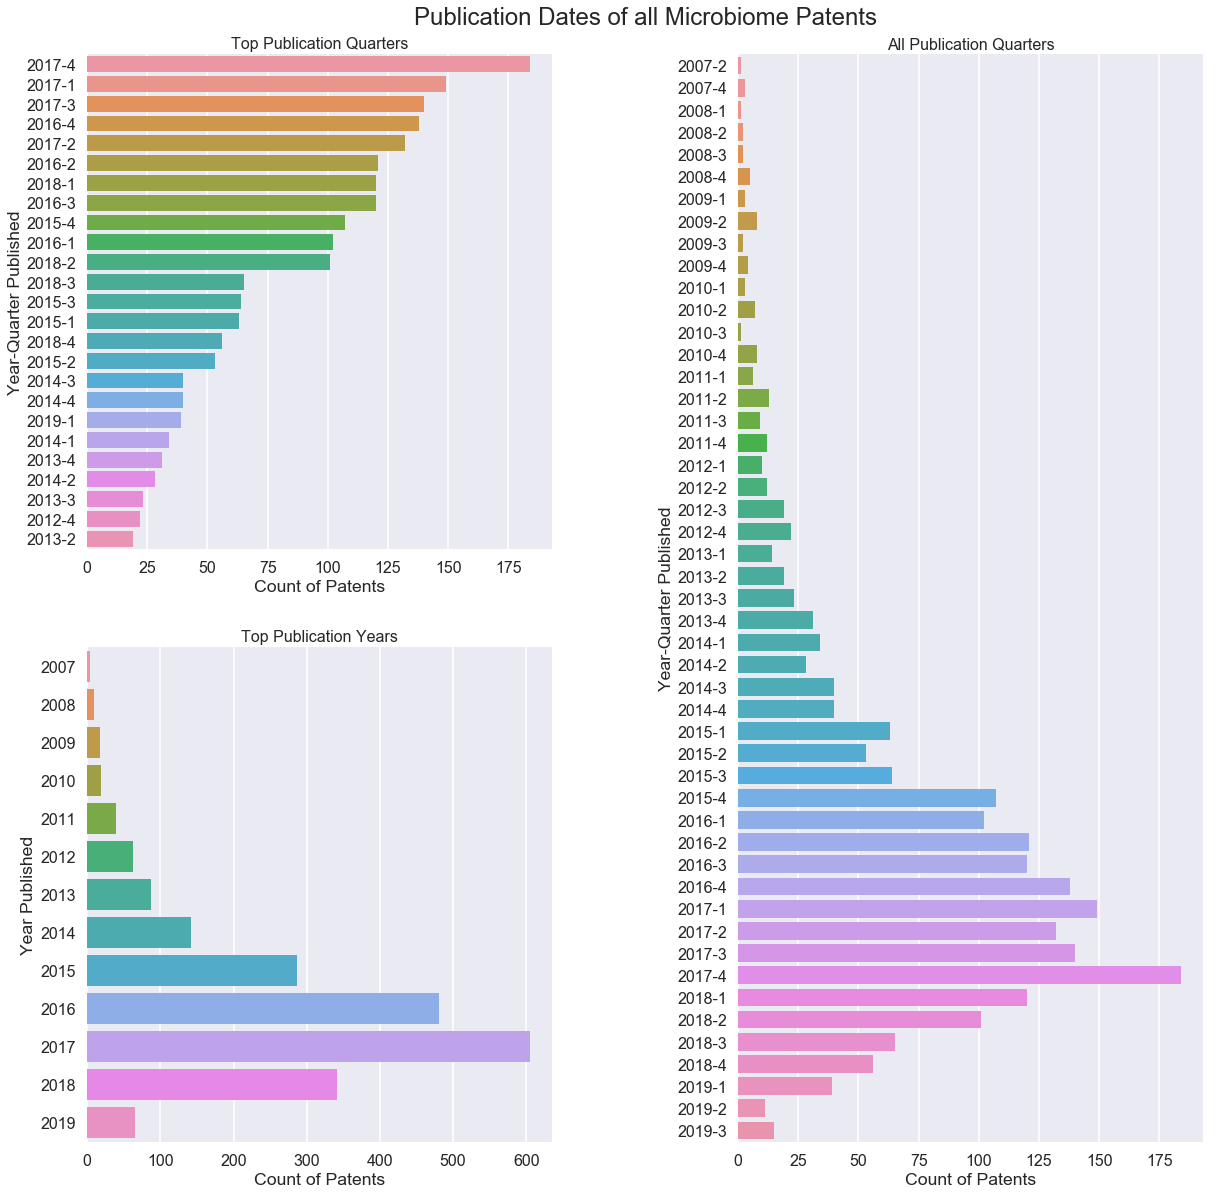

In [294]:
fig = plt.figure(figsize=(20,20), facecolor='white')
ax = fig.add_subplot(111, fc='white')    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.4)
plt.title('Publication Dates of all Microbiome Patents', pad=30, fontsize=24)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[:,1])
sns.despine()

sns.barplot(top_pubquarter_count_list, top_pubquarter_list, ax=ax1)
sns.barplot(top_pubyear_count_list, top_pubyear_list, ax=ax2, orient='horizontal')
sns.barplot(all_pubquarter_count_list, all_pub_quarters_list, ax=ax3, orient='horizontal')

ax1.set_title('Top Publication Quarters', fontsize=16)
ax2.set_title('Top Publication Years', fontsize=16)
ax3.set_title('All Publication Quarters', fontsize=16)

ax1.set_xlabel('Count of Patents')
ax2.set_xlabel('Count of Patents')
ax3.set_xlabel('Count of Patents')

ax1.set_ylabel('Year-Quarter Published')
ax2.set_ylabel('Year Published')
ax3.set_ylabel('Year-Quarter Published')

plt.show()